In [ ]:
!pip install langchain_openai langchain-mcp-adapters langgraph --quiet

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="qwen2.5-7b-instruct",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key="none",
    base_url="http://127.0.0.1:1234/v1",
)

In [3]:
# from langchain_core.messages import HumanMessage

# messages = [HumanMessage(content="Hello, how are you?")]

In [4]:
# llm.invoke(messages)

In [5]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

client = MultiServerMCPClient(
    {
        "emails": {
            "command": "python",
            "args": ["./mcp_emails.py"],
            "transport": "stdio",
        }
    }
)
tools = await client.get_tools()
agent = create_react_agent(llm, tools)


In [6]:
response = await agent.ainvoke({"messages": "Give me the new emails"})

In [7]:
response.get("messages")[-1].content

'Here is a new email you received:\n\n- **From:** prince@nigeria.gov\n- **To:** bob@example.com\n- **Subject:** Urgent: Claim your inheritance\n- **Body:** Congratulations! You\'ve been selected to receive $10 million. Please send your bank details immediately to claim your prize.\n\nThis looks like a potential scam, also known as a "Nigerian prince" email. Be cautious and do not reply with any personal information.'

In [8]:
# response

In [9]:
from typing_extensions import TypedDict
class TypedDictState(TypedDict):
    email: str

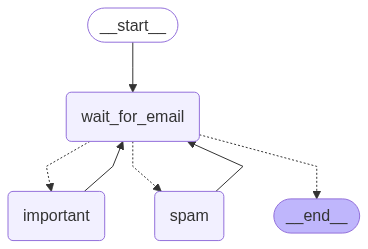

In [10]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Literal


async def wait_for_email(state):
    print("---wait_for_email---")
    response = await agent.ainvoke({"messages": "Give me the new emails"})
    return {"email": response.get("messages")[-1].content}

def spam(state):
    print(f"---process_email---\n deleted: {state.get("email")}")
    return

async def important(state):
    print("---important---")
    task = f"""Give me a short summary of
            
            Email:
            {state.get("email")}
            """
    response = await agent.ainvoke({"messages": task})
    print(f"Summary:\n {response.get("messages")[-1].content}")
    return response

async def classify_email(state) -> Literal["spam", "important"]:
    print("---process_email---")
    
    task = f"""Decide if the following email is important or spam.
                Only respond with IMPORTANT or SPAM.
                
                Email:
                {state.get("email")}
                """
    response = await agent.ainvoke({"messages": task})

    # Normalize response
    normalized = response.get("messages")[-1].content.strip().lower()

    if normalized == "important":
        return "important"
    elif normalized == "spam":
        return "spam"
    else:
        # Handle unexpected response gracefully
        print(f"⚠️ Unexpected agent response: {response!r}")
        return "spam"  # or use "important" as the fallback if more appropriate

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("wait_for_email", wait_for_email)
builder.add_node("spam", spam)
builder.add_node("important", important)

# Logic
builder.add_edge(START, "wait_for_email")
builder.add_conditional_edges("wait_for_email", classify_email)
builder.add_edge("spam", "wait_for_email")
builder.add_edge("important", "wait_for_email")

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
await graph.ainvoke({})

---wait_for_email---
